# predicting_labels_linear_regression

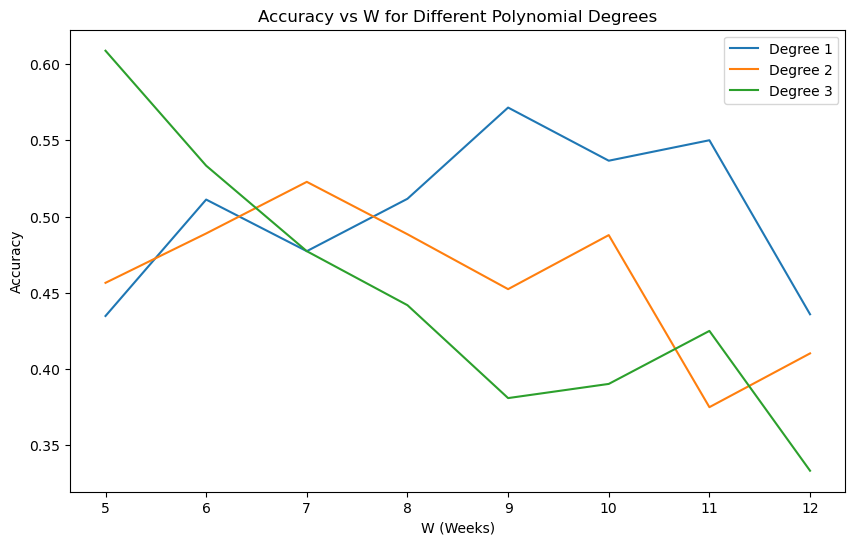

Best W for each degree: {1: 9, 2: 7, 3: 5}

Degree 1, W=9:
Accuracy: 0.6190476190476191
Confusion Matrix:
 [[ 9  9]
 [ 7 17]]

Degree 2, W=7:
Accuracy: 0.5454545454545454
Confusion Matrix:
 [[10  9]
 [11 14]]

Degree 3, W=5:
Accuracy: 0.5652173913043478
Confusion Matrix:
 [[12  9]
 [11 14]]

Degree 1 (W=9) Final Balance: 87.20494026140516

Degree 2 (W=7) Final Balance: 143.10678544571067

Degree 3 (W=5) Final Balance: 112.24162848002419


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('AAL.csv')

# Filter data for 2022 and 2023
data_2022 = data[data['Year'] == 2022]
data_2023 = data[data['Year'] == 2023]

# Get weekly closing prices for the last trading day (Friday) of each week for 2022 and 2023
weekly_closing_2022 = data_2022[data_2022['Weekday'] == 'Friday'].groupby('Week_Number')['Adj Close'].last().reset_index()
weekly_closing_2023 = data_2023[data_2023['Weekday'] == 'Friday'].groupby('Week_Number')['Adj Close'].last().reset_index()

# Define polynomial degrees and range for W values
degrees = [1, 2, 3]
Ws = range(5, 13)
accuracy_results = {degree: [] for degree in degrees}

# Question 1: Find the best W for each degree in 2022
for degree in degrees:
    for W in Ws:
        labels = []
        true_labels = data_2022[data_2022['Weekday'] == 'Friday'].loc[W:, 'Label'].values
        
        for i in range(W, len(weekly_closing_2022)):
            # Get closing prices for the last W weeks
            y_train = weekly_closing_2022['Adj Close'].iloc[i-W:i].values
            X_train = np.arange(W).reshape(-1, 1)

            # Fit polynomial model
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(X_train)
            model = LinearRegression().fit(X_poly, y_train)
            
            # Predict next week's closing price
            next_week = np.array([[W]])
            next_week_poly = poly.transform(next_week)
            predicted_price = model.predict(next_week_poly)[0]
            
            # Determine label
            last_week_price = weekly_closing_2022['Adj Close'].iloc[i - 1]
            if predicted_price > last_week_price:
                predicted_label = 'Green'
            elif predicted_price < last_week_price:
                predicted_label = 'Red'
            else:
                predicted_label = data_2022['Label'].iloc[i - 1]

            labels.append(predicted_label)
        
        # Calculate accuracy
        accuracy = accuracy_score(true_labels[:len(labels)], labels)
        accuracy_results[degree].append(accuracy)

# Plot accuracy vs W for each degree
plt.figure(figsize=(10, 6))
for degree in degrees:
    plt.plot(Ws, accuracy_results[degree], label=f'Degree {degree}')
plt.xlabel('W (Weeks)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs W for Different Polynomial Degrees')
plt.legend()
plt.show()

# Find the best W for each degree based on accuracy
best_Ws = {degree: Ws[np.argmax(accuracy_results[degree])] for degree in degrees}
print("Best W for each degree:", best_Ws)

# Question 2 and 3: Use best W to predict labels for 2023 and calculate confusion matrices
for degree in degrees:
    W = best_Ws[degree]
    labels = []
    true_labels = data_2023[data_2023['Weekday'] == 'Friday'].loc[W:, 'Label'].values

    for i in range(W, len(weekly_closing_2023)):
        y_train = weekly_closing_2023['Adj Close'].iloc[i-W:i].values
        X_train = np.arange(W).reshape(-1, 1)
        
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train)
        model = LinearRegression().fit(X_poly, y_train)

        next_week = np.array([[W]])
        next_week_poly = poly.transform(next_week)
        predicted_price = model.predict(next_week_poly)[0]

        last_week_price = weekly_closing_2023['Adj Close'].iloc[i - 1]
        if predicted_price > last_week_price:
            predicted_label = 'Green'
        elif predicted_price < last_week_price:
            predicted_label = 'Red'
        else:
            predicted_label = data_2023['Label'].iloc[i - 1]
        
        labels.append(predicted_label)

    # Accuracy and confusion matrix for each degree
    accuracy = accuracy_score(true_labels[:len(labels)], labels)
    cm = confusion_matrix(true_labels[:len(labels)], labels, labels=['Green', 'Red'])
    
    print(f"\nDegree {degree}, W={W}:")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)

# Question 4: Implement trading strategies based on best W for each degree in 2023
initial_balance = 100  # Starting balance
for degree in degrees:
    W = best_Ws[degree]
    balance = initial_balance
    position = 0  # 0: cash, 1: invested
    
    for i in range(W, len(weekly_closing_2023)):
        y_train = weekly_closing_2023['Adj Close'].iloc[i-W:i].values
        X_train = np.arange(W).reshape(-1, 1)
        
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train)
        model = LinearRegression().fit(X_poly, y_train)

        next_week = np.array([[W]])
        next_week_poly = poly.transform(next_week)
        predicted_price = model.predict(next_week_poly)[0]

        last_week_price = weekly_closing_2023['Adj Close'].iloc[i - 1]
        
        if predicted_price > last_week_price:
            if position == 0:  # Buy if not already invested
                position = balance / last_week_price
                balance = 0
        elif predicted_price < last_week_price:
            if position > 0:  # Sell if invested
                balance = position * last_week_price
                position = 0
    
    # Calculate final balance based on end-of-year price
    final_price = weekly_closing_2023['Adj Close'].iloc[-1]
    final_balance = balance + (position * final_price)
    print(f"\nDegree {degree} (W={W}) Final Balance:", final_balance)


# trend_change

In [28]:
import pandas as pd
import numpy as np
from scipy.stats import f as fisher_f
from sklearn.linear_model import LinearRegression

# Load data
data = pd.read_csv('AAL.csv')

# Filter data for years 2022 and 2023
data_2022 = data[data['Year'] == 2022]
data_2023 = data[data['Year'] == 2023]

# Function to calculate SSE for a given period
def calculate_sse(x, y):
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    sse = np.sum((y - y_pred) ** 2)
    return sse

# Function to compute F-statistic
def compute_f_statistic(L, L1, L2, n):
    f_statistic = ((L - (L1 + L2)) / 2) / ((L1 + L2) / (n - 4))
    return f_statistic

# Function to analyze a single month
def analyze_month(data_month):
    n = len(data_month)
    x = np.arange(n).reshape(-1, 1)
    y = data_month['Adj Close'].values.reshape(-1, 1)
    
    # Compute single regression SSE
    L = calculate_sse(x, y)
    
    # Search for the best break point
    best_f_stat = 0
    best_k = None
    for k in range(1, n - 1):
        x1, y1 = x[:k], y[:k]
        x2, y2 = x[k:], y[k:]
        
        # Compute two-segment SSE
        L1 = calculate_sse(x1, y1)
        L2 = calculate_sse(x2, y2)
        
        # Compute F-statistic
        f_stat = compute_f_statistic(L, L1, L2, n)
        
        # Store the best F-statistic and break point
        if f_stat > best_f_stat:
            best_f_stat = f_stat
            best_k = k
    
    # Calculate p-value
    p_value = 1 - fisher_f.cdf(best_f_stat, 2, n - 4)
    
    return best_k, best_f_stat, p_value

# Analyze all months for years 2022 and 2023
results = []
for year, data_year in zip([2022, 2023], [data_2022, data_2023]):
    for month in range(1, 13):
        data_month = data_year[data_year['Month'] == month]
        
        if len(data_month) < 4:  # Skip if there are not enough data points
            continue
        
        # Perform analysis
        best_k, best_f_stat, p_value = analyze_month(data_month)
        
        # Determine if the change is statistically significant at the 0.1 level
        significant_change = p_value < 0.1
        results.append((year, month, best_k, best_f_stat, p_value, significant_change))

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Year', 'Month', 'Best Break Day', 'F-statistic', 'p-value', 'Significant Change'])

# Output the results
print("Results of F-Test Analysis for Monthly Changes in Trend")
print(results_df)

# Answer questions
num_significant_changes_2022 = results_df[(results_df['Year'] == 2022) & (results_df['Significant Change'])].shape[0]
num_significant_changes_2023 = results_df[(results_df['Year'] == 2023) & (results_df['Significant Change'])].shape[0]

print(f"\nNumber of months with significant changes in 2022: {num_significant_changes_2022}")
print(f"Number of months with significant changes in 2023: {num_significant_changes_2023}")

if num_significant_changes_2022 > num_significant_changes_2023:
    print("There were more changes in trend in 2022 than in 2023.")
elif num_significant_changes_2022 < num_significant_changes_2023:
    print("There were more changes in trend in 2023 than in 2022.")
else:
    print("The number of changes in trend was the same for both years.")


Results of F-Test Analysis for Monthly Changes in Trend
    Year  Month  Best Break Day  F-statistic       p-value  Significant Change
0   2022      1              10    13.489329  3.689242e-04                True
1   2022      2               5    12.535662  6.301324e-04                True
2   2022      3               4    35.953101  3.479532e-07                True
3   2022      4               8    16.344256  1.360028e-04                True
4   2022      5               5    14.026681  2.524263e-04                True
5   2022      6               8    37.603842  5.731857e-07                True
6   2022      7              13    22.061147  2.515797e-05                True
7   2022      8              12    36.725328  2.964928e-07                True
8   2022      9              13    21.387715  2.282301e-05                True
9   2022     10               7     3.890973  4.061298e-02                True
10  2022     11              11    10.142728  1.261045e-03                T